In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from datasets import load_dataset
from jaxtyping import Float, Int
from typing import Callable
from torch import Tensor as TT
from transformers import AutoModelForCausalLM, AutoTokenizer

%load_ext autoreload
%autoreload 2

In [2]:
model = AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested")
tokenizer = AutoTokenizer.from_pretrained("Mlxa/brackets-nested")

In [80]:
import re


@typed
def gauss_helper(a: TT | tuple) -> TT | tuple:
    if isinstance(a, tuple):
        return tuple(gauss_helper(x) for x in a)
    else:
        assert a.numel() > 2
        mean = a.mean()
        std = a.std()
        return 0 * (t.randn_like(a) * std + mean)


@typed
def gauss_hook(
    _name: str, _module: nn.Module, _input: TT | tuple, output: TT | tuple
) -> TT | tuple:
    return gauss_helper(output)


@typed
def sh(a: TT | tuple) -> list | tuple:
    if isinstance(a, tuple):
        return tuple(sh(x) for x in a)
    else:
        return list(a.shape)


@typed
def ls(a) -> str:
    if isinstance(a, TT) and a.shape == ():
        return ls(a.item())
    if isinstance(a, float):
        return f"{a:.2f}"
    if isinstance(a, int) or isinstance(a, bool):
        return str(int(a))
    if not hasattr(a, "__len__"):
        return str(a)
    brackets = "()" if isinstance(a, tuple) else "[]"
    children = [ls(x) for x in a]
    if any("(" in x or "[" in x for x in children):
        delim = "\n"
    else:
        delim = " "
    return delim.join([brackets[0]] + children + [brackets[1]])


activations_dict: dict[str, TT | tuple] = {}


@typed
def activation_saver(
    name: str, _module: nn.Module, _input: TT | tuple, output: TT | tuple
) -> None:
    activations_dict[name] = output


class Hooks:
    @typed
    def __init__(
        self,
        module: nn.Module,
        hook: Callable[[str, nn.Module, TT, TT], TT],
    ) -> None:
        from functools import partial

        self.handles = []
        self.module = module
        for name, submodule in module.named_modules():
            if "." in name:
                self.handles.append(
                    submodule.register_forward_hook(partial(hook, name))
                )

    @typed
    def __enter__(self) -> nn.Module:
        return self.module

    @typed
    def __exit__(self, *_) -> None:
        for handle in self.handles:
            handle.remove()

In [280]:
from utils import generate_sample, get_loss, tokenize, get_logprobs, logprobs_to_losses


@typed
def nested_prompt(n: int) -> str:
    openning = " ".join(f"<{i}" for i in range(1, n + 1))
    closing = " ".join(f"{i}>" for i in range(n, 0, -1))
    return openning + " " + closing


@typed
def loss_metric(model: nn.Module, tokenizer, n: int) -> float:
    prompt = nested_prompt(n)
    return get_loss(model, tokenizer, prompt) * n


@typed
def accuracy_metric(model: nn.Module, tokenizer, n: int) -> float:
    prompt = nested_prompt(n)
    ids = tokenize(tokenizer, prompt)["input_ids"][0]
    lp = get_logprobs(model, tokenizer, prompt)
    mx = lp.argmax(dim=-1)
    correct = mx == ids
    assert correct.shape == (2 * n,)
    return correct[n:].float().mean().item()


@typed
def max_correct(model: nn.Module, tokenizer) -> int:
    l, r = 0, 64
    while r - l > 1:
        m = (l + r) // 2
        if accuracy_metric(model, tokenizer, m) > 1 - 1e-9:
            l = m
        else:
            r = m
    return l


@typed
def last_lp(model: nn.Module, tokenizer, prompt) -> float:
    stack = []
    for tok in prompt.split():
        if "<" in tok:
            stack.append(int(tok[1:]))
        elif ">" in tok:
            stack.pop()
    assert stack
    prompt += f" {stack[-1]}>"
    lp = get_logprobs(model, tokenizer, prompt)
    losses = logprobs_to_losses(lp, tokenize(tokenizer, prompt)["input_ids"][0])
    return losses[-1].item()


@typed
def random_nested_prompt(n: int) -> str:
    types = np.random.randint(0, 250, (n,))
    ids = np.concatenate((2 * types, 2 * types[::-1] + 1))
    result = tokenizer.decode(ids)
    return result


@typed
def measures_of_last_lp(n: int) -> TT:
    prompt = random_nested_prompt(n)
    parts = prompt.split()
    assert all("<" in x or ">" in x for x in parts)
    measures = []
    for i in range(1, len(parts) - 1):
        prompt = " ".join(parts[:i])
        measures.append(last_lp(model, tokenizer, prompt))
    return t.tensor(measures)

In [306]:
from tqdm import tqdm

results = t.stack([
    measures_of_last_lp(n=10) for _ in (range(20))
])

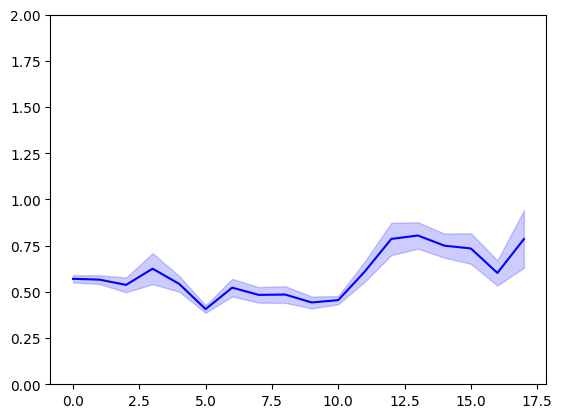

In [307]:
mean = results.mean(dim=0)
std = results.std(dim=0) / (results.shape[0] ** 0.5)
plt.plot(mean, "b")
plt.fill_between(t.arange(len(mean)), mean - std, mean + std, color="b", alpha=0.2)
plt.ylim(0, 2)
plt.show()

In [319]:
@typed
def layerwise_acts(n: int) -> TT:
    global activations_dict

    activations_dict = {}
    with Hooks(model, activation_saver):
        prompt = random_nested_prompt(n) + " " + random_nested_prompt(n)
        _ = get_loss(model, tokenizer, prompt)
    arrs = []
    for i in range(1, 6):
        act = activations_dict[f"transformer.h.{i}"][0][0, 2 * n :]
        metric = act.abs().max(dim=-1)[0]
        arr = metric.detach()
        arrs.append(arr)
    return t.stack(arrs)

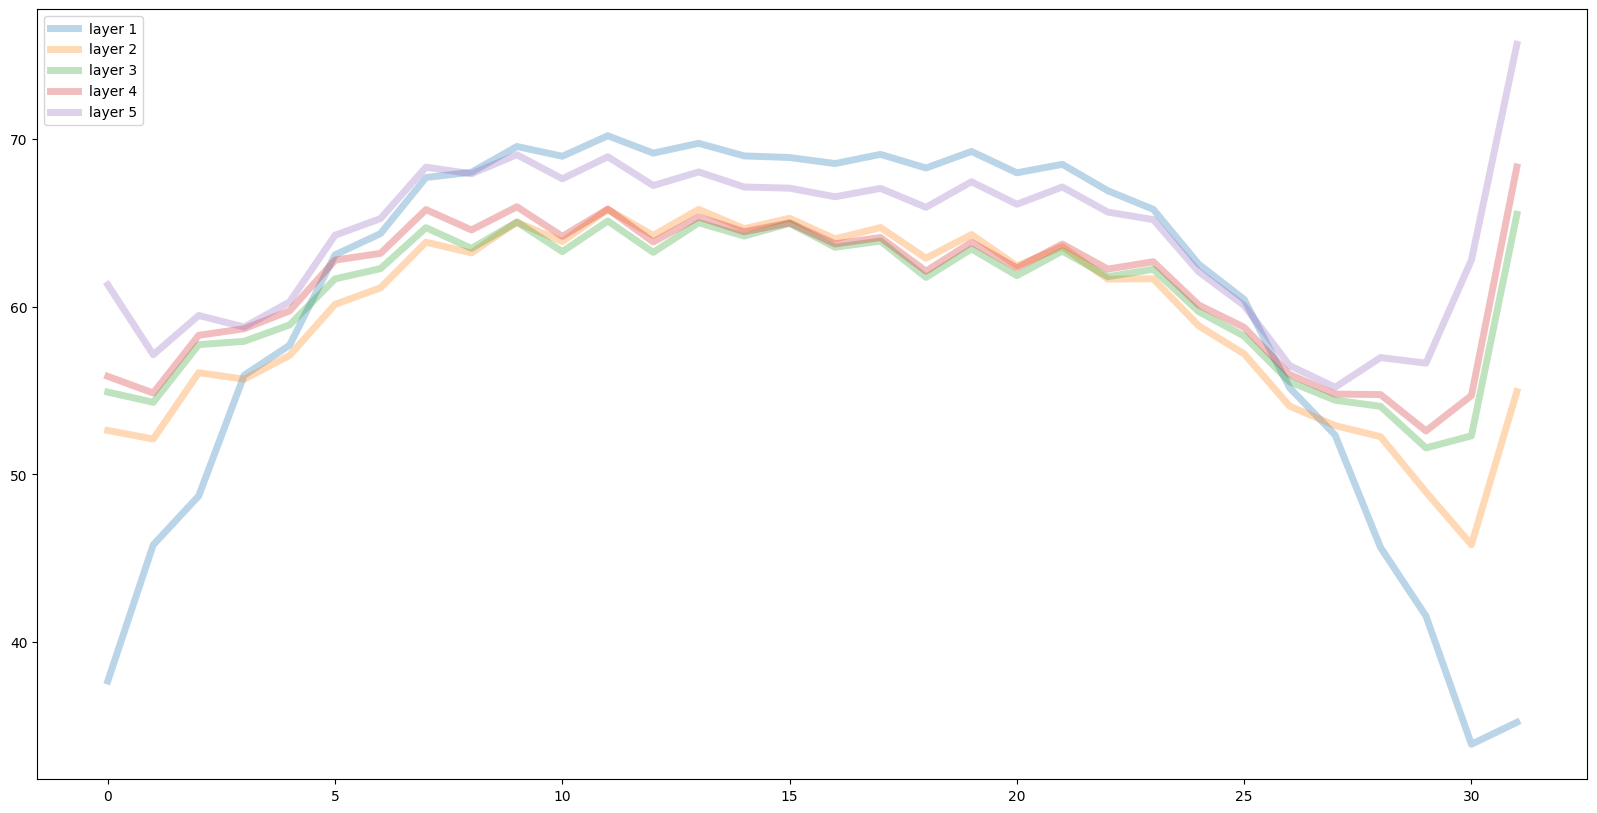

In [320]:
s = 0
k = 100
for _ in range(k):
    s += layerwise_acts(16)
s /= k

plt.figure(figsize=(20, 10))
# plt.imshow(im)
# plt.colorbar()
for i in range(len(s)):
    plt.plot(s[i], "-", label=f"layer {i+1}", lw=5, alpha=0.3)
plt.legend()
plt.show()
# print(im)

In [ ]:
n = 24
prompt = nested_prompt(n) + " " + nested_prompt(n)
lp = get_logprobs(model, tokenizer, prompt)
plt.figure(figsize=(10, 10))
plt.imshow(lp[:, 1 : 3 * (n + 1) : 2])
plt.savefig("img/observed.svg")


@typed
def analyze_orthonormality(model: nn.Module) -> None:
    embs = model.get_input_embeddings().weight.detach()
    norms = embs.norm(dim=-1)
    print(f"norms: {norms.mean().item():.3f} ± {norms.std().item():.3f}")
    A = embs @ embs.T
    print(f"covariance: {A.mean().item():.3f}, variance: {A.diag().mean().item():.3f}")


analyze_orthonormality(AutoModelForCausalLM.from_pretrained("Mlxa/brackets-nested"))
analyze_orthonormality(AutoModelForCausalLM.from_pretrained("Mlxa/brackets-flat"))
analyze_orthonormality(
    AutoModelForCausalLM.from_pretrained("Mlxa/brackets-flat_shuffle")
)
analyze_orthonormality(
    AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-8M")
)